In [50]:
%store -r full_path
import math
import numpy as np
import matplotlib.pyplot as plt

class Position:
    def __init__(self, x, y, theta=0.0):
        self.x = float(x)
        self.y = float(y)
        self.theta = float(theta)

    def distance(self, other):
        return math.hypot(self.x - other.x, self.y - other.y)

    def __sub__(self, other):
        return Position(self.x - other.x, self.y - other.y)

    def __mul__(self, other):
        if isinstance(other, Position):
            return self.x * other.x + self.y * other.y
        return Position(self.x * other, self.y * other)

    def __add__(self, other):
        return Position(self.x + other.x, self.y + other.y)

    def lerp(self, other, t):
        return Position(self.x + (other.x - self.x) * t, self.y + (other.y - self.y) * t)

    def __repr__(self):
        return f"Position(x={self.x:.2f}, y={self.y:.2f}, theta={self.theta:.2f})"

def slew(current, prev, max_change):
    return prev + np.clip(current - prev, -max_change, max_change)

In [54]:
def find_closest_point_idx(pose: Position, path: list[Position]) -> int:
    dists = [pose.distance(p) for p in path]
    return int(np.argmin(dists))

def find_circle_line_intersect_t(p1: Position, p2: Position, pose: Position, lookahead_dist: float) -> float:
    d = p2 - p1
    f = p1 - pose
    a = d * d 
    b = 2 * (f * d)
    c = (f * f) - lookahead_dist**2
    discriminant = b**2 - 4 * a * c
    if discriminant >= 0 and abs(a) >= 1e-9:
        sqrt_discriminant = math.sqrt(discriminant)
        t1 = (-b - sqrt_discriminant) / (2 * a)
        t2 = (-b + sqrt_discriminant) / (2 * a)
        if 0 <= t2 <= 1:
            return t2
        if 0 <= t1 <= 1:
            return t1
    return -1.0

def get_lookahead_point(last_lookahead_info: Position, current_pose: Position, path: list[Position], 
                        closest_path_idx: int, lookahead_dist: float) -> Position:
    if len(path) < 2:
        return last_lookahead_info 

    start_segment_idx = int(last_lookahead_info.theta)
    effective_start_idx = min(max(closest_path_idx, start_segment_idx), len(path) - 2)

    for i in range(effective_start_idx, len(path) - 1):
        p1 = path[i]
        p2 = path[i+1]
        t_intersect = find_circle_line_intersect_t(p1, p2, current_pose, lookahead_dist)
        if 0 <= t_intersect <= 1:
            found_lookahead_pt = p1.lerp(p2, t_intersect)
            found_lookahead_pt.theta = float(i) 
            return found_lookahead_pt

    if current_pose.distance(path[-1]) < lookahead_dist:
        final_pt_info = Position(path[-1].x, path[-1].y, float(max(0, len(path) - 2)))
        return final_pt_info
        
    return last_lookahead_info

def get_lookahead_curvature(current_pose: Position, current_heading_rad: float, lookahead_pt: Position) -> float:
    dx = lookahead_pt.x - current_pose.x
    dy = lookahead_pt.y - current_pose.y
    
    y_local_coord = -dx * math.sin(current_heading_rad) + dy * math.cos(current_heading_rad)
    dist_sq_to_lookahead = dx**2 + dy**2

    if dist_sq_to_lookahead < 1e-6:
        return 0.0
        
    return (2 * y_local_coord) / dist_sq_to_lookahead

In [73]:
class RobotSimState:
    def __init__(self, x: float = 0.0, y: float = 0.0, theta_rad: float = 0.0):
        self.x = x
        self.y = y
        self.theta_rad = theta_rad

    def get_pose_obj(self) -> Position:
        return Position(self.x, self.y, self.theta_rad)

    def update(self, v_left: float, v_right: float, dt: float, wheelbase: float):
        v_center = (v_left + v_right) / 2.0
        omega = (v_right - v_left) / wheelbase

        self.x += v_center * math.cos(self.theta_rad) * dt
        self.y += v_center * math.sin(self.theta_rad) * dt
        
        new_theta = self.theta_rad + omega * dt
        self.theta_rad = math.atan2(math.sin(new_theta), math.cos(new_theta))

    def __repr__(self) -> str:
        return f"RobotSimState(x={self.x:.2f}, y={self.y:.2f}, theta={math.degrees(self.theta_rad):.1f}°)"

GRID_CELL_SIZE_METERS = 0.1
WHEELBASE_METERS = 0.14
MAX_ROBOT_SPEED_MPS = 0.2 
TARGET_VELOCITY_MPS = 0.15 
LOOKAHEAD_DIST_METERS = 0.02

DT = 0.05
SIMULATION_DURATION_S = 60 
TARGET_REACHED_THRESHOLD_METERS = 0.01 
SLEW_RATE_SPEED_MPS_PER_S = 0.5 
MIN_TARGET_SPEED_MPS = 0.05 

In [71]:
path_positions = [Position(c * GRID_CELL_SIZE_METERS, r * GRID_CELL_SIZE_METERS) for r, c in full_path]

def pure_pursuit_controller(robot: RobotSimState, path: list[Position], lookahead_dist: float, 
                            target_speed: float, wheelbase: float, max_abs_speed: float, 
                            dt: float, goal_threshold: float, max_duration: float,
                            min_abs_speed: float, slew_accel_limit: float):
    
    if len(path) < 2:
        print("Path is too short to follow.")
        return np.array([(robot.x, robot.y, robot.theta_rad)]), np.array([])

    path_history = []
    lookahead_history = []
    
    last_lookahead_info = Position(path[0].x, path[0].y, 0.0) 
    
    previous_actual_speed = 0.0
    elapsed_time = 0.0
    num_steps = int(max_duration / dt)

    for _ in range(num_steps):
        path_history.append((robot.x, robot.y, robot.theta_rad))
        current_pose = robot.get_pose_obj()
        
        closest_idx = find_closest_point_idx(current_pose, path)
        dist_to_final_goal = current_pose.distance(path[-1])

        if dist_to_final_goal < goal_threshold and closest_idx >= len(path) - 2 :
            print(f"Robot reached end of path at t={elapsed_time:.2f}s.")
            break

        current_lookahead_pt = get_lookahead_point(last_lookahead_info, current_pose, path, closest_idx, lookahead_dist)
        last_lookahead_info = current_lookahead_pt
        lookahead_history.append((current_lookahead_pt.x, current_lookahead_pt.y))

        curvature = get_lookahead_curvature(current_pose, robot.theta_rad, current_lookahead_pt)
        
        turn_reduction = 0.5 if abs(curvature * wheelbase) > 0.7 else 1.0
        
        slowing_dist_factor = lookahead_dist * 2.0 
        end_reduction = 1.0
        if dist_to_final_goal < slowing_dist_factor and slowing_dist_factor > 0:
            scale = dist_to_final_goal / slowing_dist_factor
            end_reduction = (min_abs_speed / target_speed if target_speed > 0 else 0) + \
                            (1.0 - (min_abs_speed / target_speed if target_speed > 0 else 0)) * scale
            end_reduction = np.clip(end_reduction, (min_abs_speed / target_speed if target_speed > 0 else 0), 1.0)

        desired_speed = target_speed * turn_reduction * end_reduction
        desired_speed = max(min_abs_speed, desired_speed)

        actual_speed = slew(desired_speed, previous_actual_speed, slew_accel_limit * dt)
        previous_actual_speed = actual_speed

        v_l = actual_speed * (1 - (curvature * wheelbase) / 2.0)
        v_r = actual_speed * (1 + (curvature * wheelbase) / 2.0)

        max_wheel_val = max(abs(v_l), abs(v_r))
        if max_wheel_val > max_abs_speed:
            norm_factor = max_abs_speed / max_wheel_val
            v_l *= norm_factor
            v_r *= norm_factor
        
        v_l = np.clip(v_l, -max_abs_speed, max_abs_speed)
        v_r = np.clip(v_r, -max_abs_speed, max_abs_speed)

        robot.update(v_l, v_r, dt, wheelbase)
        elapsed_time += dt
    else:
        print(f"Simulation ended due to max duration ({max_duration:.1f}s).")

    robot.update(0, 0, dt, wheelbase)
    path_history.append((robot.x, robot.y, robot.theta_rad))
    
    return np.array(path_history), np.array(lookahead_history)

if path_positions:
    init_x = path_positions[0].x
    init_y = path_positions[0].y
    init_theta = 0.0
    if len(path_positions) > 1:
        dx_init = path_positions[1].x - init_x
        dy_init = path_positions[1].y - init_y
        init_theta = math.atan2(dy_init, dx_init)

    robot_instance = RobotSimState(x=init_x, y=init_y, theta_rad=init_theta)

    sim_robot_path, sim_lookahead_pts = pure_pursuit_controller(
        robot_instance, path_positions, 
        LOOKAHEAD_DIST_METERS, TARGET_VELOCITY_MPS, WHEELBASE_METERS, MAX_ROBOT_SPEED_MPS, 
        DT, TARGET_REACHED_THRESHOLD_METERS, SIMULATION_DURATION_S,
        MIN_TARGET_SPEED_MPS, SLEW_RATE_SPEED_MPS_PER_S
    )
    print(f"Robot final state: {robot_instance}")
else:
    print("Path is empty. Skipping Pure Pursuit simulation.")
    robot_instance = RobotSimState() 
    sim_robot_path, sim_lookahead_pts = np.array([]), np.array([])

Simulation ended due to max duration (60.0s).
Robot final state: RobotSimState(x=0.26, y=0.23, theta=-8.4°)


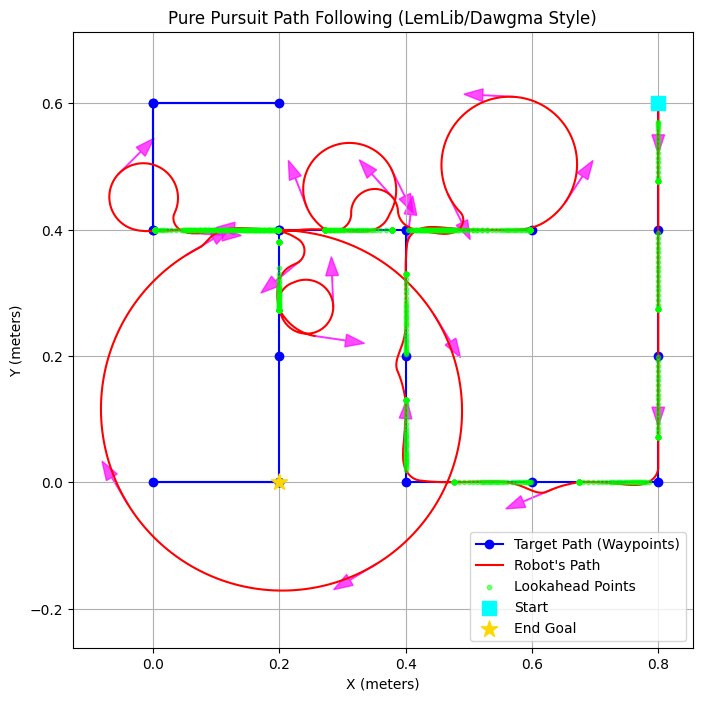

In [ ]:
plt.figure(figsize=(8, 8))
path_xy = np.array([(p.x, p.y) for p in path_positions])
plt.plot(path_xy[:, 0], path_xy[:, 1], 'bo-', label="Target Path (Waypoints)")
if sim_robot_path.shape[0] > 0:
    plt.plot(sim_robot_path[:, 0], sim_robot_path[:, 1], 'r-', label="Robot's Path")
    for i in range(0, len(sim_robot_path), max(1, len(sim_robot_path)//20)):
        x, y, theta = sim_robot_path[i]
        plt.arrow(x, y, 0.05 * math.cos(theta), 0.05 * math.sin(theta), head_width=0.02, head_length=0.03, fc='magenta', ec='magenta', alpha=0.7)
if sim_lookahead_pts.shape[0] > 0:
    plt.scatter(sim_lookahead_pts[:, 0], sim_lookahead_pts[:, 1], c='lime', s=10, label="Lookahead Points", alpha=0.5, zorder=3)
plt.scatter(path_positions[0].x, path_positions[0].y, c='cyan', marker='s', s=100, label="Start", zorder=5)
plt.scatter(path_positions[-1].x, path_positions[-1].y, c='gold', marker='*', s=150, label="End Goal", zorder=5)
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.title("Pure Pursuit Path Following")
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()